In [58]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from joblib import Parallel, delayed

In [4]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'datasets')

In [5]:
# cds_csv_path = os.path.join(data_dir, 'cds.csv')
# cds_data = pd.read_csv(cds_csv_path, index_col='Date')

In [6]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [ ]:
ticks_DF_dict = {}

for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

In [9]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

    px_columns = [f'PX{i}' for i in range(1, 11)]

    # if ticker not in dataset:
    #     print(f"Ticker '{ticker}' not found in the dataset.")
    #     return

    tickerset = dataset[ticker]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        if col not in tickerset.columns:
            print(f"Column '{col}' not found for ticker '{ticker}'.")
            continue

        price_col = tickerset[col].dropna()

        if not price_col.empty:
            if squared:
                plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
            else:
                plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')

            axes[i].set_xlim(lagmin, lagmax)
            axes[i].set_xlabel("Lags")
            axes[i].set_ylabel("Autocorrelation")
        else:
            axes[i].set_title(f"Autocorr: {col} (No Data)")

    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

In [11]:
def calculate_log_returns(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_dict = {}

    for ticker, df in dataset.items():
        returns_df = df.copy()
        for col in px_columns:
            # apply log returns transformation for each column
            # returns_df[col] = 100*df[col].pct_change()
            returns_df[col] = (np.log(df[col]) - np.log(df[col].shift(1))) * 100
        returns_dict[ticker] = returns_df.dropna()

    return returns_dict

In [12]:
def calculate_first_diffs(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    diffs_dict = {}

    for ticker, df in dataset.items():
        returns_df = df.copy()
        for col in px_columns:
            # apply log returns transformation for each column
            returns_df[col] = df[col] - df[col].shift(1)
        diffs_dict[ticker] = returns_df.dropna()

    return diffs_dict

In [120]:
cds_returns_dict = calculate_log_returns(ticks_DF_dict)

In [32]:
cds_diffs_dict = calculate_first_diffs(ticks_DF_dict)

In [87]:
cds_returns_dict['AAPL']['PX1'].mean()

0.002367651946801046

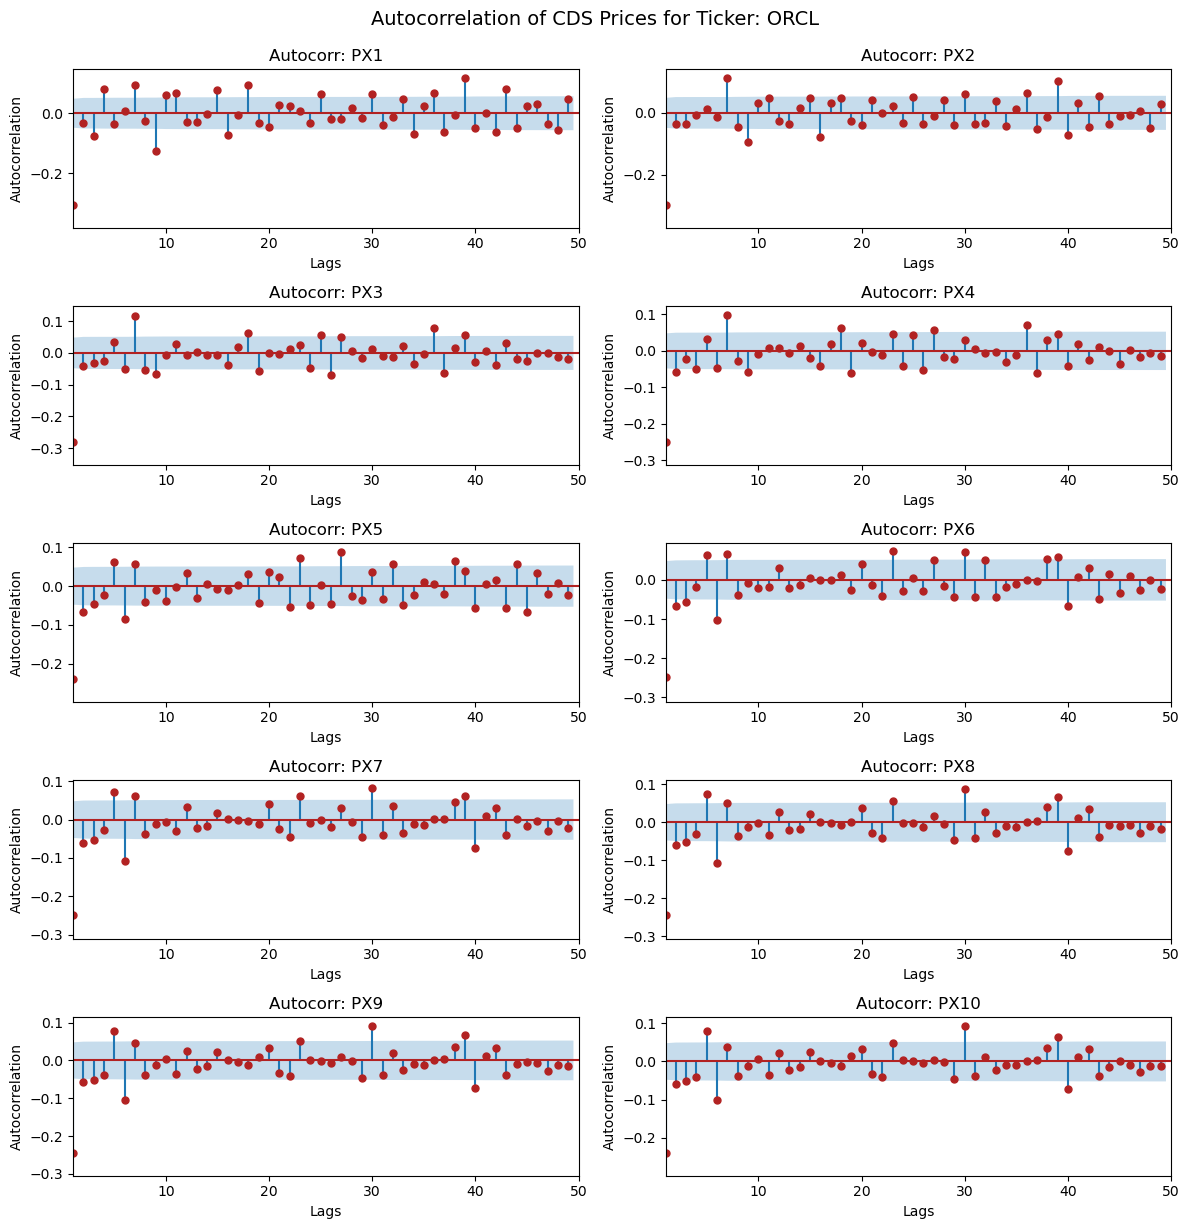

In [88]:
autocorrelation_plotter(cds_returns_dict, 'ORCL')

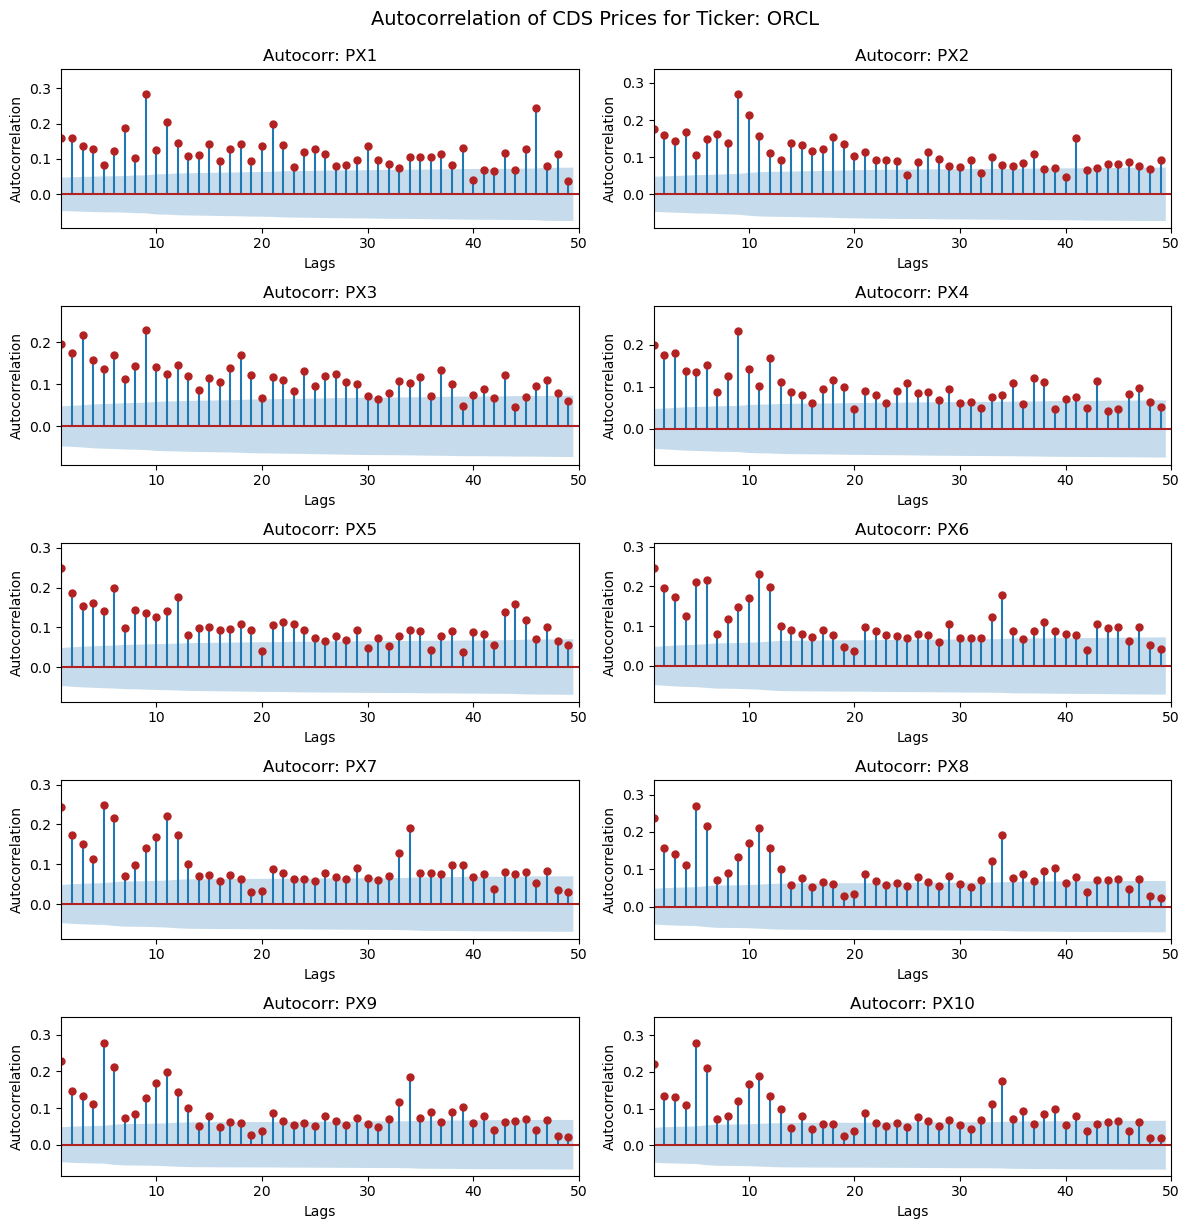

In [89]:
autocorrelation_plotter(cds_returns_dict, 'ORCL', squared=True)

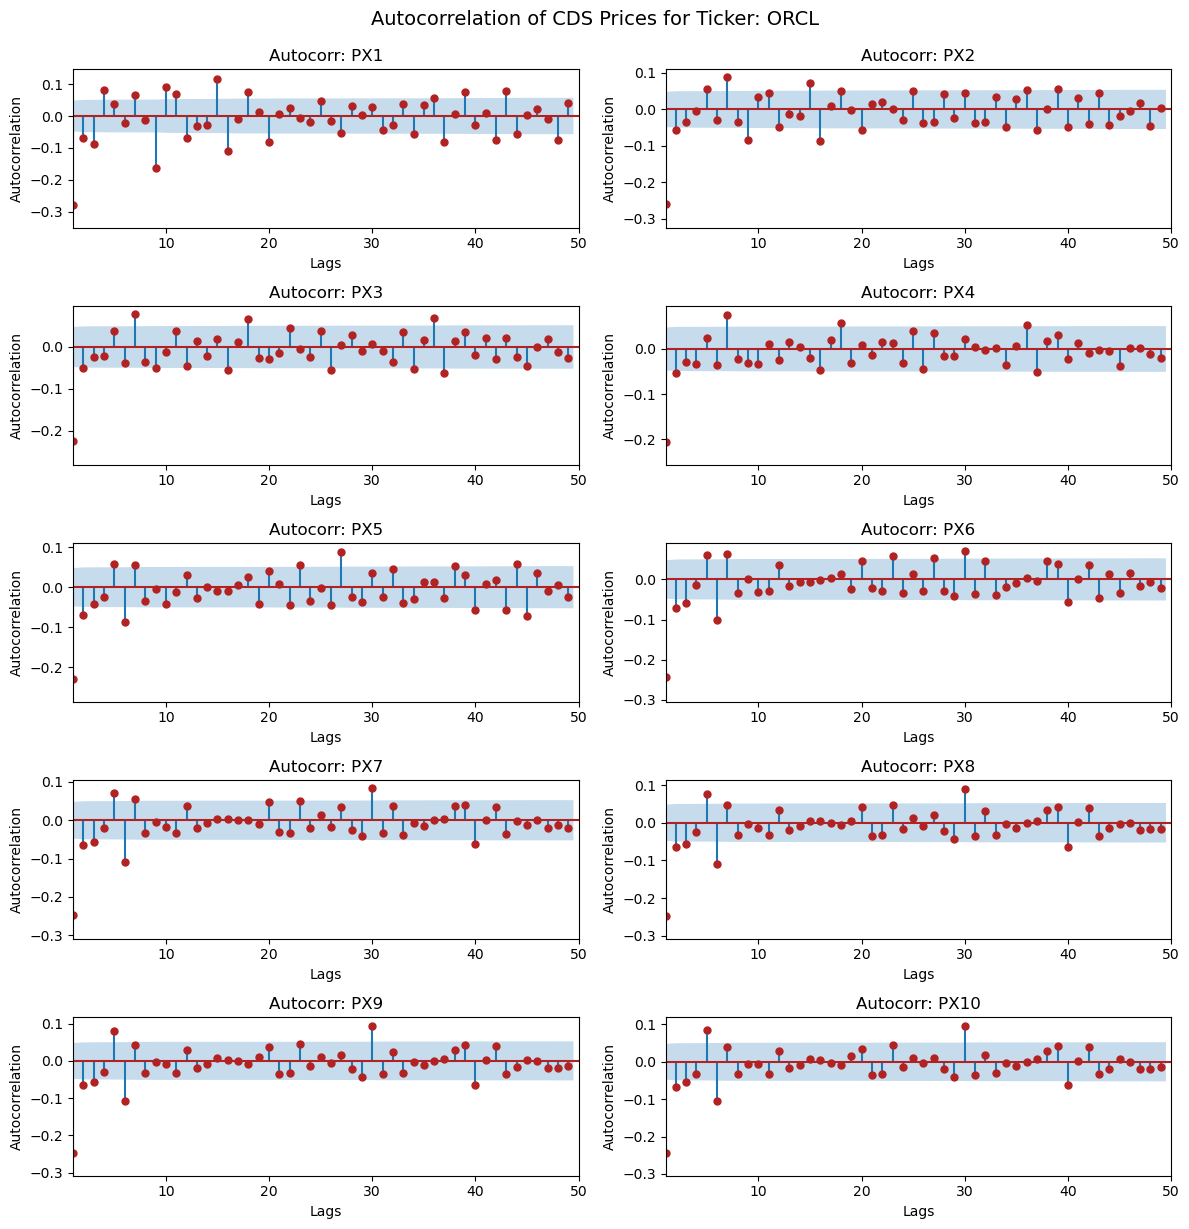

In [36]:
autocorrelation_plotter(cds_diffs_dict, 'ORCL')

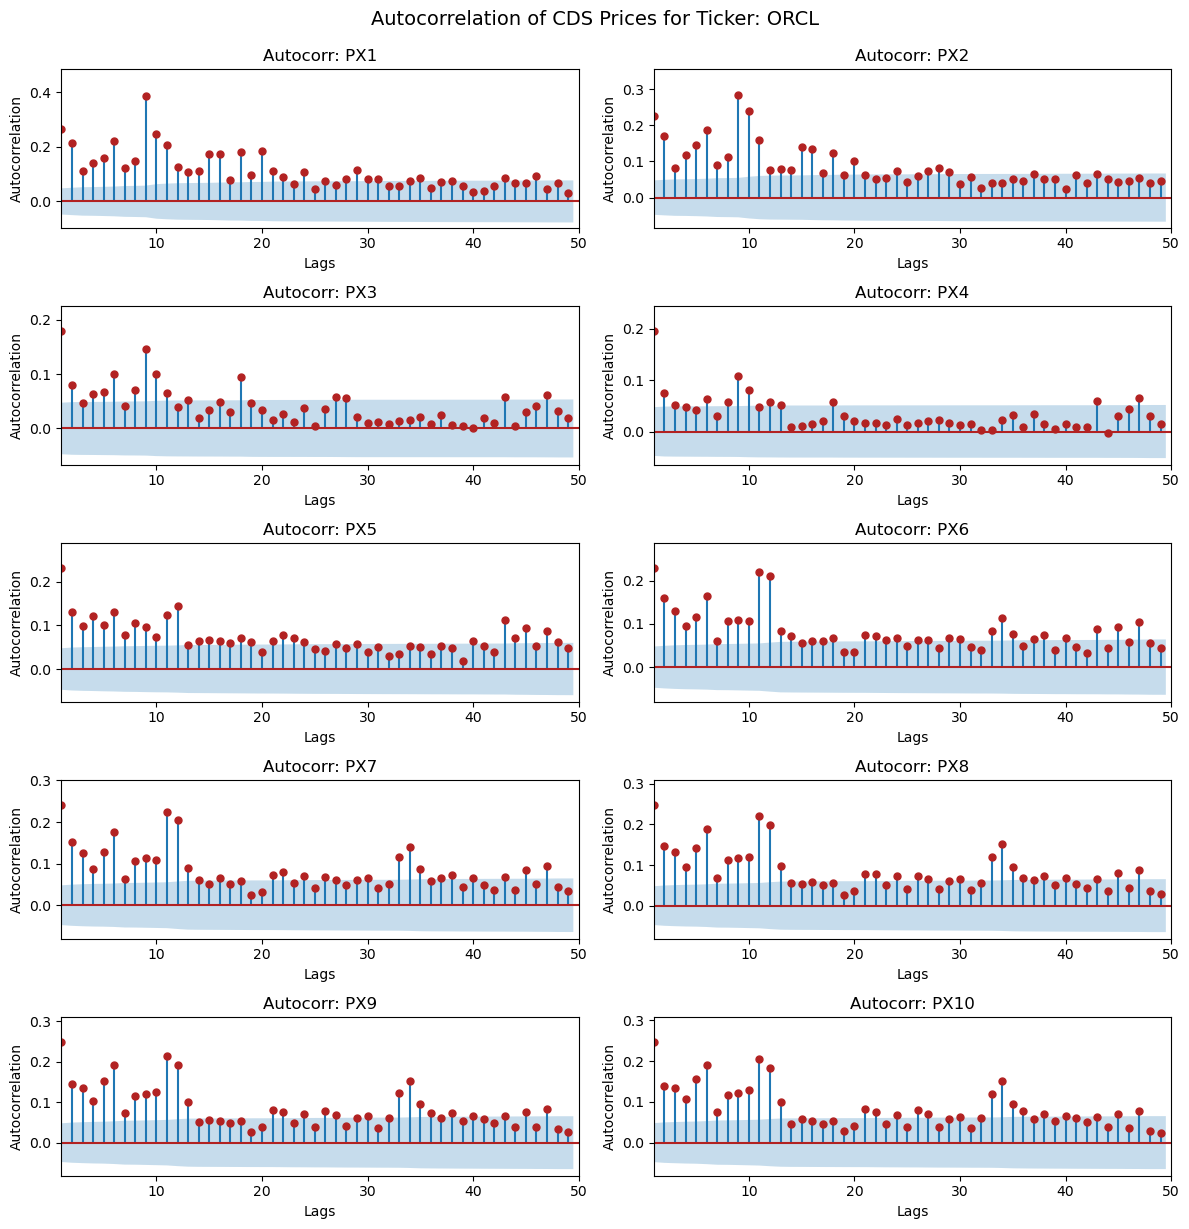

In [37]:
autocorrelation_plotter(cds_diffs_dict, 'ORCL', squared=True)

In [38]:
def split_train_test(cds_returns, split_date='2020-01-01'):
    train_set = {}
    test_set = {}

    for ticker, df in cds_returns.items():
        train_set[ticker] = df[df.index < split_date]
        test_set[ticker] = df[df.index >= split_date]
    
    return train_set, test_set

In [121]:
cds_returns_train, cds_returns_testfull = split_train_test(cds_returns_dict)
cds_returns_test, additional_test = split_train_test(cds_returns_testfull, split_date='2021-01-01')

In [40]:
cds_diffs_train, cds_diffs_testfull = split_train_test(cds_diffs_dict)
cds_diffs_test, additional_test_diff = split_train_test(cds_diffs_testfull, split_date='2021-01-01')

We can see that a GARCH model is appropriate here

Imported Parallel and delayed otherwise this code would take excessively long to run (days)

In [94]:
from joblib import Parallel, delayed

def fit_garch(data, p, q):
    model = arch_model(data, p=p, q=q, mean='Zero').fit(disp='off')
    return p, q, model.aic

In [42]:
def AIC_picker(dataset, max_p=3, max_q=3):
    px_columns = [f'PX{i}' for i in range(1, 11)]    
    results = {}

    # Iterate over tickers (keys in dataset dictionary)
    for ticker, df in dataset.items():
        results[ticker] = {}
        
        for col in px_columns:
            if col in df.columns:
                subset = df[col].dropna()
                if subset.empty:
                    results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
                    continue
                
                # Parallel fitting of GARCH models
                fit_results = Parallel(n_jobs=-1)(delayed(fit_garch)(subset, p, q) for p in range(1, max_p + 1) for q in range(1, max_q + 1))
                
                # Initialize with GARCH(1,1)
                best_aic = fit_garch(subset, p=1, q=1)[-1]
                best_order = (1, 1)

                for p, q, aic in fit_results:
                    if aic < best_aic:  # Minimize AIC
                        best_aic = aic
                        best_order = (p, q)

                results[ticker][col] = {'best_p': best_order[0], 'best_q': best_order[1], 'AIC': best_aic}
            else:
                results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
    
    return results

In [43]:
aic_values_garch = AIC_picker(cds_diffs_train)

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

In [44]:
# aic_values_garch = AIC_picker(cds_returns_train)

In [45]:
aic_values_garch

{'A': {'PX1': {'best_p': 1, 'best_q': 3, 'AIC': 2756.9526752247075},
  'PX2': {'best_p': 2, 'best_q': 3, 'AIC': 3809.5592836848023},
  'PX3': {'best_p': 2, 'best_q': 3, 'AIC': 4948.103176114468},
  'PX4': {'best_p': 2, 'best_q': 3, 'AIC': 5902.784865737},
  'PX5': {'best_p': 2, 'best_q': 3, 'AIC': 6308.246539792665},
  'PX6': {'best_p': 1, 'best_q': 3, 'AIC': 6825.192507775503},
  'PX7': {'best_p': 1, 'best_q': 3, 'AIC': 7084.578991925897},
  'PX8': {'best_p': 2, 'best_q': 2, 'AIC': 7363.717334284206},
  'PX9': {'best_p': 1, 'best_q': 3, 'AIC': 7402.964520261543},
  'PX10': {'best_p': 1, 'best_q': 3, 'AIC': 7485.800728567812}},
 'AALLN': {'PX1': {'best_p': 2, 'best_q': 2, 'AIC': 6388.496391093824},
  'PX2': {'best_p': 3, 'best_q': 3, 'AIC': 7651.254569716193},
  'PX3': {'best_p': 1, 'best_q': 2, 'AIC': 8259.353686849463},
  'PX4': {'best_p': 3, 'best_q': 3, 'AIC': 8497.161789736645},
  'PX5': {'best_p': 3, 'best_q': 3, 'AIC': 8635.191374472874},
  'PX6': {'best_p': 1, 'best_q': 3, 'AIC

In [46]:
# # Parameters
# num_sims = 1000

# # Forecast 1-day returns for the test set using fitted GARCH parameters and actual observed test data
# def forecast_test_returns(train_set, test_set, aic_results, num_simulations=num_sims, column='PX1'):
#     forecasts = {}

#     for ticker in test_set.keys():

#         train_df = train_set[ticker]
#         test_df = test_set[ticker]

#         if column in train_df.columns and column in test_df.columns:
#             # retrieve best GARCH(p, q) orders
#             best_p = aic_results.get(ticker, {}).get(column, {}).get('best_p', 1)
#             best_q = aic_results.get(ticker, {}).get(column, {}).get('best_q', 1)

#             if not best_p or not best_q:
#                 print(f"Skipping {ticker} as no valid GARCH parameters found.")
#                 forecasts[ticker] = None
#                 continue

#             # fit GARCH on the train set
#             train_returns = train_df[column].dropna()
#             model = arch_model(train_returns, vol='Garch', p=best_p, q=best_q, mean='Zero')
#             model_fit = model.fit(disp='off')

#             forecasts[ticker] = []
#             rolling_volatility = np.sqrt(model_fit.forecast(horizon=1).variance.values[-1, -1])
#             previous_return = train_returns.iloc[-1]

#             # iteratively forecast 1-day ahead returns for the test set using observed data
#             for t in range(len(test_df)):
#                 omega = model_fit.params['omega']
#                 alpha = model_fit.params['alpha[1]']
#                 beta = model_fit.params['beta[1]']

#                 observed_return = test_df[column].iloc[t-1] if t > 0 else previous_return
#                 observed_squared = observed_return**2

#                 gjr_forecast = omega + alpha * observed_squared + beta * rolling_volatility**2
#                 rolling_volatility = np.sqrt(gjr_forecast)

#                 # Monte Carlo simulation for 1-day returns
#                 simulated_returns = rolling_volatility * np.random.randn(num_simulations)
#                 mean_forecast_return = simulated_returns.mean()
#                 forecasts[ticker].append(mean_forecast_return)

#                 previous_return = test_df[column].iloc[t]
#         else:
#             forecasts[ticker] = None

#     return forecasts

In [ ]:
def WalkForwardARIMA(tDF, test_year, colname, order=False, plot=True):

    # Train-test split
    train_set = tDF[tDF.index.year < test_year][colname]#.asfreq(freq='B', method='bfill')
    test_set  = tDF[tDF.index.year == test_year][colname]#.asfreq(freq='B', method='bfill')

    if not order: #Select best p, d and q based on AIC fitting
        auto_model = auto_arima(train_set, seasonal=False, trace=False)
        order = auto_model.order

    history = list(train_set)
    model = ARIMA(train_set.values, order=order)
    model_fitted = model.fit()
    forecasts = []
    CI_ints = []
    for i in range(len(test_set)):

        forecast_result = model_fitted.get_forecast(steps=1)
        forecasts.append(forecast_result.predicted_mean[0])
        
        conf_int = forecast_result.conf_int(alpha=0.05)[0]
        CI_ints.append((conf_int[0], conf_int[1]))

        actual_value = test_set.iloc[i]
        history.append(actual_value)
        
        model_fitted = model_fitted.append([actual_value], refit=False)
    
    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set.index, test_set, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set.index, forecasts, color='red', alpha=0.6, label="Forecasted Data")
        lower_bounds = [ci[0] for ci in CI_ints]
        upper_bounds = [ci[1] for ci in CI_ints]
        plt.fill_between(test_set.index, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="95% CI-interval")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"ARIMA Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()

    result_frame = pd.DataFrame({
        'date': test_set.index,
        'actual': test_set.values,
        'preds': forecasts,
        'lower_95': [ci[0] for ci in CI_ints],
        'upper_95': [ci[1] for ci in CI_ints]
    })
    
    return result_frame

result_frame = WalkForwardARIMA(ticks_DF_dict['AAPL'], 2020, "PX1", order=(1,1,1))

In [53]:
def forecast_returns_1day(tDF, test_year, colname='PX1', vol_model='GARCH', plot=True):

    np.random.seed(1)
    
    tDF_return = (np.log(tDF[colname]) - np.log(tDF[colname].shift(1))) * 100
    tDF_return = tDF_return.dropna()

    train_set_spread = tDF[tDF.index.year < test_year][colname]#.asfreq(freq='B', method='bfill')
    test_set_spread  = tDF[tDF.index.year == test_year][colname]#.asfreq(freq='B', method='bfill')

    train_set = tDF_return[tDF_return.index.year < test_year]#.asfreq(freq='B', method='bfill')
    test_set = tDF_return[tDF_return.index.year == test_year]#.asfreq(freq='B', method='bfill')

    history = list(train_set)
    history_spread = list(train_set_spread)

    if vol_model == 'GARCH':
        model = arch_model(train_set, p=1, q=1, mean='Constant')
    elif vol_model == 'GJR-GARCH':
        model = arch_model(train_set, p=1, o=1, q=1, mean='Constant')
    elif vol_model == 'ARCH':
        model = arch_model(train_set, vol=vol_model, p=1)
    else:
        raise ValueError
    
    model_fitted = model.fit()
    mu = model_fitted.params['mu']
    forecasts = []
    forecast_returns = []
    CI_ints_returns = []
    CI_ints = []

    for i in range(len(test_set)):
        forecast_sigma = np.sqrt(model_fitted.forecast(horizon=1).variance.values[-1,0])
        random_shock = np.random.normal()
        forecast_return = mu + forecast_sigma * random_shock
        forecast_returns.append(forecast_return)

        if i == 0:
            yesterday_spread = train_set_spread.iloc[-1]
        else:
            yesterday_spread = test_set_spread.iloc[i-1]
        history_spread.append(yesterday_spread)

        forecast_spread = (1 + forecast_return/100) * yesterday_spread
        forecasts.append(forecast_spread)

        actual_return = test_set.iloc[i]
        history.append(actual_return)

        lower_ci = mu - 1.96 * forecast_sigma
        upper_ci = mu + 1.96 * forecast_sigma
        lower_ci_spread = yesterday_spread * (1 + lower_ci/100)
        upper_ci_spread = yesterday_spread * (1 + upper_ci/100)
        
        CI_ints_returns.append((lower_ci, upper_ci))
        CI_ints.append((lower_ci_spread, upper_ci_spread))

    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set.index, test_set_spread.values, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set.index, forecasts, color='red', alpha=0.6, label="Forecasted Data")
        lower_bounds = [ci[0] for ci in CI_ints]
        upper_bounds = [ci[1] for ci in CI_ints]
        plt.fill_between(test_set.index, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="95% CI-interval")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"GARCH(1,1) Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()

    result_frame = pd.DataFrame({
        'date': test_set.index,
        'actual': test_set_spread.values,
        'preds': forecasts,
        'lower_95': [ci[0] for ci in CI_ints_returns],
        'upper_95': [ci[1] for ci in CI_ints_returns]
    })

    return result_frame

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4249.251773420609
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4222.852897565492
Iteration:      3,   Func. Count:     15,   Neg. LLF: 4289.5964942016
Iteration:      4,   Func. Count:     21,   Neg. LLF: 4222.6930371401395
Iteration:      5,   Func. Count:     25,   Neg. LLF: 4222.692875501769
Iteration:      6,   Func. Count:     28,   Neg. LLF: 4222.6928755017925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4222.692875501769
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6


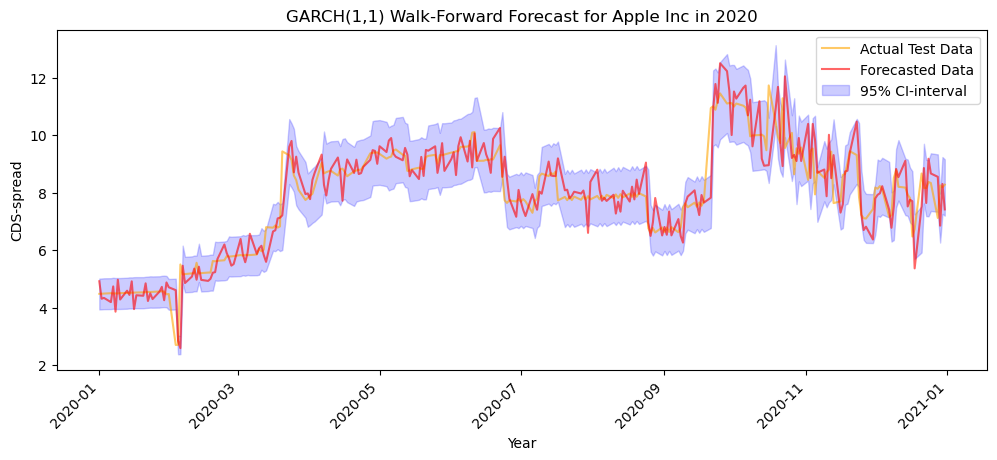

In [54]:
arch_test = forecast_returns_1day(tDF=ticks_DF_dict['AAPL'], test_year=2020, vol_model="ARCH")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2593427.948683917
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4752.418733262667
Iteration:      3,   Func. Count:     19,   Neg. LLF: 5576.094977043058
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4544.788152074578
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4188.4478160227045
Iteration:      6,   Func. Count:     38,   Neg. LLF: 4288.188706615778
Iteration:      7,   Func. Count:     44,   Neg. LLF: 4130.639964836093
Iteration:      8,   Func. Count:     49,   Neg. LLF: 4130.622457466723
Iteration:      9,   Func. Count:     54,   Neg. LLF: 4130.622176157503
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4130.622070505446
Iteration:     11,   Func. Count:     64,   Neg. LLF: 4130.622066304253
Iteration:     12,   Func. Count:     68,   Neg. LLF: 4130.622066304085
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4130.622066304253
            Iterations: 12


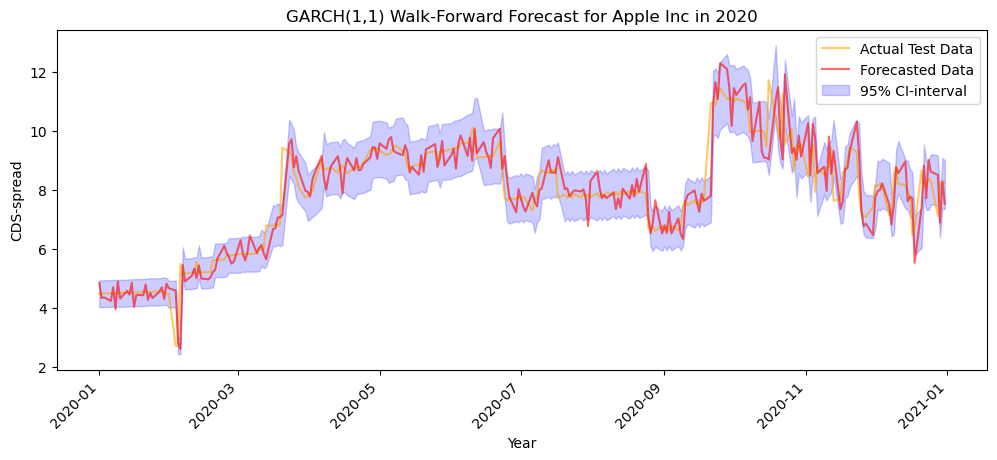

In [47]:
apple_test = forecast_returns_1day(tDF=ticks_DF_dict['AAPL'], test_year=2020)

In [61]:
def parallel_walkforward_arch(tDF_dict, test_year, colname, vol_model):
    """ Parallelized Walk-Forward ARIMA fitting and forecasting for multiple tickers. """
    results = Parallel(n_jobs=-1)(delayed(forecast_returns_1day)(tDF, test_year, colname, vol_model=vol_model, plot=False) for tick, tDF in tDF_dict.items())

    return {tick: frame for tick, frame in zip(tDF_dict.keys(), results)}

In [62]:
GARCH_tDF_dict = parallel_walkforward_arch(ticks_DF_dict, 2020, "PX1", 'GARCH')
ARCH_tDF_dict = parallel_walkforward_arch(ticks_DF_dict, 2020, "PX1", 'ARCH')
GJR_GARCH_tDF_dict = parallel_walkforward_arch(ticks_DF_dict, 2020, "PX1", 'GJR-GARCH')

In [65]:
def createPanelDataframe(model_tDF_dict):
    for tick, DF in model_tDF_dict.items():
        DF['tick'] = tick
        if not 'panelDF' in locals():
            panelDF = DF
        else:
            panelDF = pd.concat([panelDF, DF])
    return panelDF.reset_index(drop=True)

In [66]:
panel_GARCH = createPanelDataframe(GARCH_tDF_dict)
panel_ARCH = createPanelDataframe(ARCH_tDF_dict)
panel_GJR_GARCH = createPanelDataframe(GJR_GARCH_tDF_dict)

In [68]:
panel_GARCH.to_csv('datasets/GARCH/GARCH_forecast.csv')
panel_ARCH.to_csv('datasets/ARCH/ARCH_forecast.csv')
panel_GJR_GARCH.to_csv('datasets/GJR_GARCH/GJR_GARCH_forecast.csv')

In [ ]:
# def ten_day_price_forecast(dataset, model_results, K=10, MC=10000, dist='Normal', n_jobs=-1, mc_jobs=-1):

#     def simulate_mc_batch(batch_size, shocks, omega, alpha, beta, one_day_variance, K):

#         cond_variance = np.zeros((K, batch_size))
#         cond_variance[0, :] = one_day_variance

#         for k in range(1, K):
#             cond_variance[k, :] = omega + alpha * (shocks[k-1, :] ** 2) + beta * cond_variance[k-1, :]

#         sim_returns = np.sqrt(cond_variance) * shocks
#         sim_cumulative_returns = np.cumsum(sim_returns, axis=0)
#         return sim_cumulative_returns

#     def simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K):

#         # fit GARCH
#         model = arch_model(subset, vol='Garch', p=p_opt, q=q_opt, mean='Zero', rescale=True)
#         result = model.fit(disp="off")
        
#         # 1-day ahead variance forecast
#         forecast = result.forecast(horizon=1)
#         one_day_ahead_variance = forecast.variance.iloc[-1, 0]

#         # GARCH params
#         omega = result.params['omega']
#         alpha = result.params['alpha[1]']
#         beta = result.params['beta[1]']

#         # Monte Carlo shocks
#         batch_size = MC // 10  # Split into 10 batches
#         total_batches = 10

#         if dist == 'Normal':
#             shocks = [np.random.randn(K, batch_size) for _ in range(total_batches)]
#         else:
#             d1 = result.distribution.df
#             shocks = [np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=(K, batch_size)) for _ in range(total_batches)]

#         # parallelize Monte Carlo batches
#         mc_results = Parallel(n_jobs=mc_jobs)(delayed(simulate_mc_batch)(batch_size, shocks[i], omega, alpha, beta, one_day_ahead_variance, K) for i in range(total_batches))

#         return np.hstack(mc_results)

#     # parallel Execution
#     px_columns = [f'PX{i}' for i in range(1, 11)]
#     tickers = dataset['Ticker'].unique()
#     forecast_results = {}

#     for col in px_columns:
#         forecast_results[col] = {}

#         def process_ticker(ticker):
#             subset = dataset[dataset['Ticker'] == ticker][col].dropna()

#             p_opt = model_results[col][ticker]['best_p']
#             q_opt = model_results[col][ticker]['best_q']

#             # sim cumulative returns
#             sim_cumulative_returns = simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K)
#             return ticker, sim_cumulative_returns

#         # parallel processing for all tickers
#         results = Parallel(n_jobs=n_jobs)(delayed(process_ticker)(ticker) for ticker in tickers)

#         for ticker, simulation_results in results:
#             if simulation_results is not None:
#                 forecast_results[col][ticker] = simulation_results

#     return forecast_results

In [ ]:
# def forecast_all_paths(cds_returns, returns_forecast):

#     px_columns = [f'PX{i}' for i in range(1, 11)]
#     tickers = cds_returns['Ticker'].unique()

#     all_paths_forecast = {}

#     for col in px_columns:
#         all_paths_forecast[col] = {}

#         for ticker in tickers:
#             last_price = cds_returns[cds_returns['Ticker'] == ticker][col].dropna().iloc[-1]
#             sim_cumulative_returns = returns_forecast[col][ticker]  # shape: (K, MC)

#             # convert cum. returns to prices - * 10**4 because prices in bps 
#             price_paths = last_price * np.exp(sim_cumulative_returns / 100)

#             all_paths_forecast[col][ticker] = price_paths

#     return all_paths_forecast